In [29]:
# sales_forecasting_example.ipynb

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [42]:
# 1. Load raw sales data from ABC store
df = pd.read_csv("../data/Sales Prediction.csv")

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Drop rows where BOTH month and sales are NaN
df = df.dropna(subset=["month", "sales"], how="all").reset_index(drop=True)

# ---------- remove obvious outliers ----------
# 1) remove zero or negative sales
df = df[df["sales"] > 0].copy()

# 2) remove statistical outliers using IQR
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

# this factor (1.5) usually catches "the weird spikes" like the ones in your plot
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()


# Overview of the raw data
print(df.head())
print(df.info())

   month      sales
0    1.0  24.321676
1    2.0  29.212176
2    3.0  33.632435
3    4.0  27.904117
4    5.0  31.633817
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   97 non-null     float64
 1   sales   97 non-null     float64
dtypes: float64(2)
memory usage: 2.3 KB
None


In [43]:
# CASE 1: "month" is just a running number (1, 2, 3, ...) and we want to start at 2020-01
start_date = pd.Timestamp("2016-01-01")

# create a proper datetime column based on row position
# if your "month" column is 1-based and strictly increasing, we can do:
df["date"] = [start_date + pd.DateOffset(months=int(m - 1)) for m in df["month"]]

# # now we use "date" as the true time index
df = df.sort_values("date").reset_index(drop=True)

# # Overview of the raw data
print(df.head())
print(df.tail())

   month      sales       date
0    1.0  24.321676 2016-01-01
1    2.0  29.212176 2016-02-01
2    3.0  33.632435 2016-03-01
3    4.0  27.904117 2016-04-01
4    5.0  31.633817 2016-05-01
    month       sales       date
92   96.0  170.254691 2023-12-01
93   97.0  180.410457 2024-01-01
94   98.0  180.751846 2024-02-01
95   99.0  185.935582 2024-03-01
96  100.0  185.827322 2024-04-01


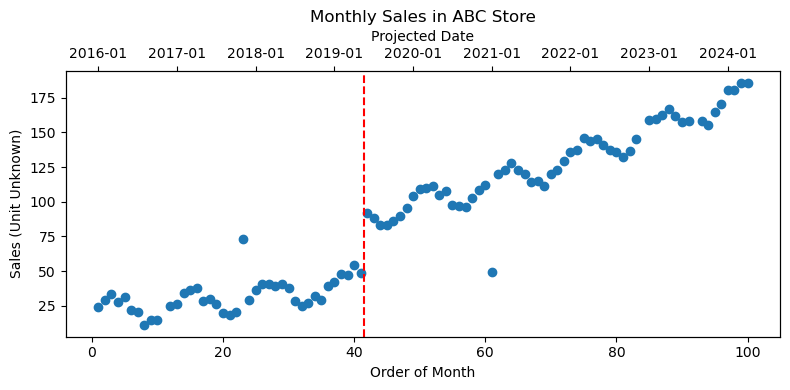

In [44]:
# Quick look at the data
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot sales using the bottom x-axis (month)
ax1.plot(df.month, df.sales, 'o')
ax1.set_xlabel('Order of Month')
ax1.set_ylabel('Sales (Unit Unknown)')
ax1.set_title('Monthly Sales in ABC Store')

# Create a secondary x-axis on top for date
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Show only January dates on the upper x-axis
january_mask = df.date.dt.month == 1
jan_months = df.month[january_mask]
jan_labels = df.date[january_mask].dt.strftime('%Y-%m')

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel('Projected Date')

ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.show()

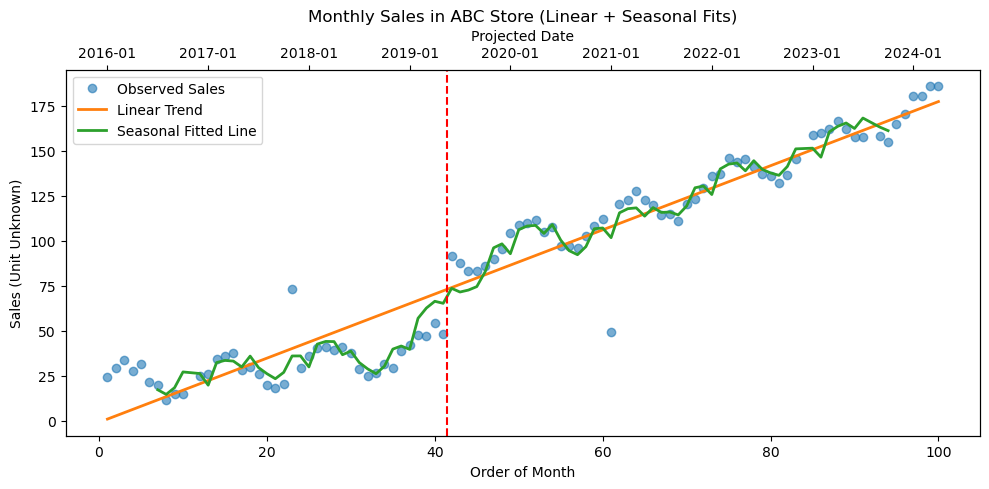

In [50]:
# 2. Linear regression fit
df2 = df.copy()   # ✅ make a copy before modifying

X = df2["month"].values.reshape(-1, 1)
y = df2["sales"].values
linreg = LinearRegression()
linreg.fit(X, y)
df2["trend_linear"] = linreg.predict(X)

# 3. Seasonal decomposition (using statsmodels)
df2 = df2.set_index("date")
result = seasonal_decompose(df2["sales"], model="additive", period=12)
df2["seasonal_fit"] = result.trend + result.seasonal

# 4. Plot data + linear fit + seasonal fit with two x-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bottom x-axis: month (numeric order)
ax1.plot(df2["month"], df2["sales"], "o", label="Observed Sales", alpha=0.6)
ax1.plot(df2["month"], df2["trend_linear"], "-", label="Linear Trend", linewidth=2)
ax1.plot(df2["month"], df2["seasonal_fit"], "-", label="Seasonal Fitted Line", linewidth=2)
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Linear + Seasonal Fits)")

# Top x-axis: only January labels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

january_mask = df2.index.month == 1
jan_months = df2["month"][january_mask]
jan_labels = df2.index[january_mask].strftime("%Y-%m")

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel("Projected Date")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [49]:
df2

,month,sales,trend_linear,seasonal_fit
date,,,,
2016-01-01,1.0,24.321676,1.005307,NaN
2016-02-01,2.0,29.212176,2.787339,NaN
2016-03-01,3.0,33.632435,4.569371,NaN
2016-04-01,4.0,27.904117,6.351403,NaN
2016-05-01,5.0,31.633817,8.133435,NaN
...,...,...,...,...
2023-12-01,96.0,170.254691,170.298363,NaN
2024-01-01,97.0,180.410457,172.080395,NaN
2024-02-01,98.0,180.751846,173.862427,NaN


In [20]:
# 3. Target
target_col = "sales"

# 4. Basic time features (use the unified 'date' column)
df["fea_year"] = df["date"].dt.year
df["fea_month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek  # for monthly data this will be similar, but ok to keep

# 5. Lag features
df["lag_1"] = df[target_col].shift(1)
df["lag_2"] = df[target_col].shift(2)
df["lag_7"] = df[target_col].shift(7)  # for monthly data this is a 7-month lag

# 6. Rolling features (use shifted target to avoid lookahead)
df["roll_3"] = df[target_col].shift(1).rolling(window=3).mean()
df["roll_6"] = df[target_col].shift(1).rolling(window=6).mean()

# Drop rows with NaN created by lagging/rolling
df = df.dropna().reset_index(drop=True)

# Quick look
print(df.head())
print(df.tail())

   month      sales       date  fea_year  fea_month  dayofweek      lag_1  \
0    8.0  11.334801 2016-08-01      2016          8          0  20.134899   
1    9.0  14.980235 2016-09-01      2016          9          3  11.334801   
2   10.0  14.990533 2016-10-01      2016         10          5  14.980235   
3   12.0  24.821180 2016-12-01      2016         12          3  14.990533   
4   13.0  26.051368 2017-01-01      2017          1          6  24.821180   

       lag_2      lag_7     roll_3     roll_6  
0  21.722341  24.321676  24.497019  27.373297  
1  20.134899  29.212176  17.730680  24.393735  
2  11.334801  33.632435  15.483312  21.285035  
3  14.980235  27.904117  13.768523  19.132771  
4  14.990533  31.633817  18.263982  17.997331  
    month       sales       date  fea_year  fea_month  dayofweek       lag_1  \
85   96.0  170.254691 2023-12-01      2023         12          4  164.711280   
86   97.0  180.410457 2024-01-01      2024          1          0  170.254691   
87   98.0

In [8]:
# 7. Train/test split (last 24 months as test, adjust if your data is shorter)
test_size = 24 if len(df) > 24 else int(len(df) * 0.2)
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

feature_cols = [
    "fea_year",
    "fea_month",
    "dayofweek",
    "lag_1",
    "lag_2",
    "lag_7",
    "roll_3",
    "roll_6",
]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [9]:
# 8. Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# 8.1 Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
evaluate_model("LinearRegression", y_test, y_pred_lr)

# 8.2 Simple Neural Network
nn = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    random_state=42,
    max_iter=500
)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
evaluate_model("NeuralNetwork", y_test, y_pred_nn)

# 8.3 Optional: Logistic Regression (classification style, not ideal here)
sales_bins = pd.qcut(train_df[target_col], q=3, labels=[0, 1, 2])
log_clf = LogisticRegression(max_iter=500)
log_clf.fit(X_train, sales_bins)
test_bins_pred = log_clf.predict(X_test)
print("LogisticRegression (classification) predicted bins:", np.unique(test_bins_pred))


LinearRegression: MAE=16.08, RMSE=34.25
NeuralNetwork: MAE=26.58, RMSE=37.75
LogisticRegression (classification) predicted bins: [2]


/Users/kevinchao/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# 9. Forecast next 24 months
date_col = 'date'

last_date = df[date_col].max()
future_steps = 24  # 2 years of monthly data

future_rows = []
current_df = df.copy()

for i in range(1, future_steps + 1):
    next_date = last_date + pd.DateOffset(months=i)

    row = {}
    row[date_col] = next_date
    row["fea_year"] = next_date.year
    row["fea_month"] = next_date.month
    row["dayofweek"] = next_date.dayofweek

    # lags from current_df (which we extend as we go)
    row["lag_1"] = current_df[target_col].iloc[-1]
    row["lag_2"] = current_df[target_col].iloc[-2]
    row["lag_7"] = current_df[target_col].iloc[-7] if len(current_df) >= 7 else current_df[target_col].iloc[0]

    row["roll_3"] = current_df[target_col].iloc[-3:].mean()
    row["roll_6"] = current_df[target_col].iloc[-6:].mean() if len(current_df) >= 6 else current_df[target_col].mean()

    row_df = pd.DataFrame([row])

    # predict with linear regression
    y_fut = lin_reg.predict(row_df[feature_cols])[0]

    # add to current_df for next loop
    new_row_full = {
        date_col: next_date,
        target_col: y_fut,
        "fea_year": row["fea_year"],
        "fea_month": row["fea_month"],
        "dayofweek": row["dayofweek"],
        "lag_1": row["lag_1"],
        "lag_2": row["lag_2"],
        "lag_7": row["lag_7"],
        "roll_3": row["roll_3"],
        "roll_6": row["roll_6"],
    }
    current_df = pd.concat([current_df, pd.DataFrame([new_row_full])], ignore_index=True)
    future_rows.append({date_col: next_date, target_col: y_fut})

future_df = pd.DataFrame(future_rows)
print("Future prediction (next 24 months):")
print(future_df)

Future prediction (next 24 months):
         date       sales
0  2024-05-01  185.932128
1  2024-06-01  188.351863
2  2024-07-01  196.325363
3  2024-08-01  198.560752
4  2024-09-01  200.388422
5  2024-10-01  209.669017
6  2024-11-01  209.023506
7  2024-12-01  210.124041
8  2025-01-01  214.581750
9  2025-02-01  213.932123
10 2025-03-01  215.983294
11 2025-04-01  222.391114
12 2025-05-01  223.031395
13 2025-06-01  222.623102
14 2025-07-01  229.578326
15 2025-08-01  229.483644
16 2025-09-01  236.484060
17 2025-10-01  238.037912
18 2025-11-01  237.427908
19 2025-12-01  244.587950
20 2026-01-01  243.239144
21 2026-02-01  241.784064
22 2026-03-01  242.984679
23 2026-04-01  248.153224


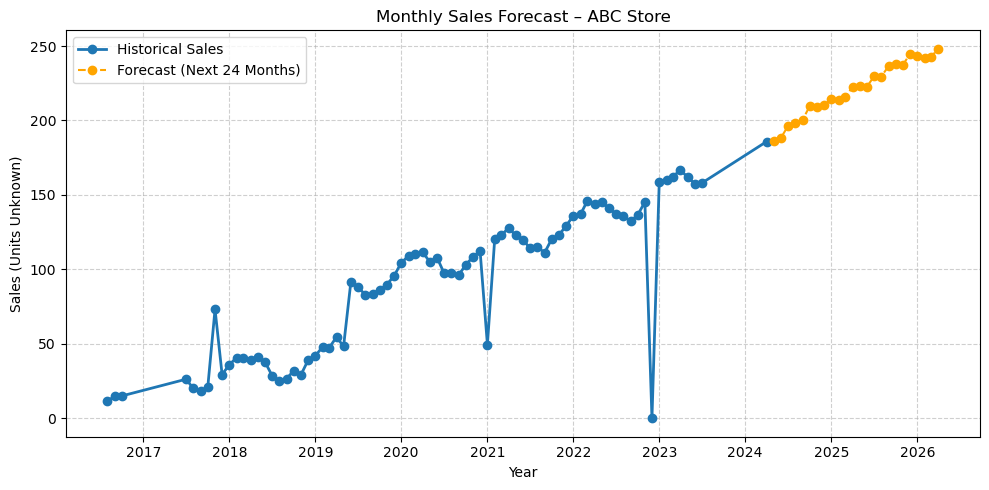

In [11]:
import matplotlib.pyplot as plt

# Combine historical and forecast data
df_plot = pd.concat([df[["date", "sales"]], future_df], ignore_index=True)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["sales"], 'o-', label="Historical Sales", linewidth=2)
plt.plot(future_df["date"], future_df["sales"], 'o--', label="Forecast (Next 24 Months)", color="orange")

plt.title("Monthly Sales Forecast – ABC Store")
plt.xlabel("Year")
plt.ylabel("Sales (Units Unknown)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
